In [1]:
# Read in the data
import pandas as pd #Scale the data
import numpy as np

import matplotlib.pyplot as plt

#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words as stop_words
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO
from bs4 import BeautifulSoup

import string
import re
import spacy

import gensim.downloader as api

from sklearn.metrics import accuracy_score,f1_score
#import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_hub as hub
import tensorflow_text as text

import seaborn as sns 
import time

import warnings
warnings.filterwarnings("ignore")

from official.nlp import optimization  # to create AdamW optimizer

[nltk_data] Downloading package wordnet to /home/mantel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-04-20 16:37:20.651887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 16:37:21.983219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-20 16:37:23.440000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 16:37:23.441607: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen som

In [2]:
df = pd.read_csv('train.csv')# Set variables for the targets and features

In [3]:
df = df.drop(['id','keyword','location'],axis=1)

In [4]:
#nlp = spacy.load('en_core_web_sm')

stopwords = stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

#converting emojis
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

#removing html code
def remove_html(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    return text

#removing urls
def remove_urls(text):
    pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    text = re.sub(pattern, "", text)
    return text

#removing mentions
def remove_mentions(text):
    pattern = re.compile(r"@\w+")
    text = re.sub(pattern, "", text)
    return text

#removing punctuations
def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [5]:
df['text_clean'] = df['text'].apply(convert_emojis)
df['text_clean'] = df['text_clean'].apply(remove_html)
df['text_clean'] = df['text_clean'].apply(remove_urls)
df['text_clean'] = df['text_clean'].apply(remove_mentions)
df['text_clean'] = df['text_clean'].apply(remove_punctuations)

#df['text'] = df['text'].apply(clean)

df = df.dropna().drop_duplicates()
df = df.reset_index()

In [6]:
#docs = list(df['text'])

X_train, X_test, y_train, y_test = train_test_split(df['text_clean'],df['target'],random_state=42)

In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
    
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    
}


In [8]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2023-04-20 16:37:37.878801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-20 16:37:37.879216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-20 16:37:37.879346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-20 16:37:37.879717: I tensorflow/core/

In [10]:
text_test = X_train
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (5640, 128)
Word Ids   : [  101  2025  2000  5254  1037  2350 12130  2000  1996  5754 19190 29545]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(128, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(16, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1,activation='sigmoid')(net)

  return tf.keras.Model(text_input, net)

In [12]:
classifier_model = build_classifier_model()

2023-04-20 16:37:40.327350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-20 16:37:40.327771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-20 16:37:40.327903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-20 16:37:40.328276: I tensorflow/core/

In [13]:
tf.keras.utils.plot_model(classifier_model,rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [15]:
epochs = 10
steps_per_epoch = 40
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
classifier_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy',f1_m,precision_m, recall_m])


In [18]:
print(f'Training model with {tfhub_handle_encoder}')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               epochs=epochs,
                               callbacks=[early_stop],
                               validation_data=(X_test,y_test))

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


2023-04-20 16:37:45.536177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-04-20 16:37:45.536278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_2' with dtype int32 and shape [?,128]
	 [[{{node inputs_2}}]]
2023-04-20 16:37:47.315953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPart

177/177 [==============================] - 452s 3s/step - loss: 0.5411 - accuracy: 0.7232 - f1_m: 0.6782 - precision_m: 0.6992 - recall_m: 0.6865 - val_loss: 0.4462 - val_accuracy: 0.8028 - val_f1_m: 0.7623 - val_precision_m: 0.7474 - val_recall_m: 0.7931
Epoch 2/10
177/177 [==============================] - 446s 3s/step - loss: 0.4096 - accuracy: 0.8317 - f1_m: 0.7864 - precision_m: 0.8420 - recall_m: 0.7504 - val_loss: 0.4361 - val_accuracy: 0.8161 - val_f1_m: 0.7713 - val_precision_m: 0.7756 - val_recall_m: 0.7804
Epoch 3/10
177/177 [==============================] - 447s 3s/step - loss: 0.3740 - accuracy: 0.8436 - f1_m: 0.8030 - precision_m: 0.8580 - recall_m: 0.7646 - val_loss: 0.4292 - val_accuracy: 0.8203 - val_f1_m: 0.7723 - val_precision_m: 0.7943 - val_recall_m: 0.7665
Epoch 4/10
177/177 [==============================] - 451s 3s/step - loss: 0.3698 - accuracy: 0.8530 - f1_m: 0.8097 - precision_m: 0.8704 - recall_m: 0.7694 - val_loss: 0.4292 - val_accuracy: 0.8203 - val_f1_m:

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


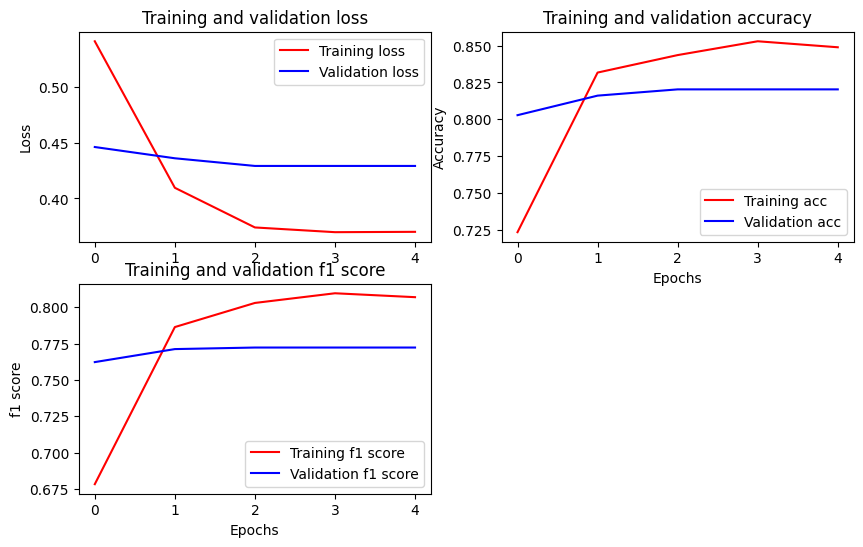

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
f1 = history_dict['f1_m']
val_f1 = history_dict['val_f1_m']
epochs = history.epoch

fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 2, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(epochs, f1, 'r', label='Training f1 score')
plt.plot(epochs, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.xlabel('Epochs')
plt.ylabel('f1 score')
plt.legend(loc='lower right')

In [23]:
X_test

2338    Doing Giveaway Music Kit Dren Death s Head Dem...
7251     IDFire Parker Ridge Fact Sheet Aug 6 2015  Pa...
5859    Vacation update  my great aunt just killed a s...
6608    The Flash And The Thunder by WC Quick on Amazo...
676     Morgan Silver Dollar 1880 S Gem BU DMPL Cameo ...
                              ...                        
6092    Thu Aug 06 2015 01 20 32 GMT 0000  UTC \n mill...
7201    In   We highly recommend   Titania  A whirlwin...
4310    Governor allows parole for California school b...
6556    Me pulling over and fighting the hoes that cal...
2499    going to redo my nails and watch behind the sc...
Name: text_clean, Length: 1881, dtype: object

In [22]:
y_pred = classifier_model.predict(X_test)

59/59 [==============================] - 39s 654ms/step


In [40]:
wrong_classified= []
for i in range(len(y_pred)):
    label = y_pred[i][0]>0.5
    if label != y_test.iloc[i]:
        wrong_classified.append([y_pred[i][0],X_test.iloc[i]])

In [44]:
wrong_classified

[[0.14139217,
  'Vacation update  my great aunt just killed a spider with her bare hand after I screamed in fear   fierce'],
 [0.9769072,
  'Mourning notices for stabbing arson victims stir \x89Û÷politics of grief\x89Ûª in Israel  Posters for Shira Banki and A    '],
 [0.07794506, 'Remove the  and Linkury Browser Hijacker  '],
 [0.3373947, 'I will adamantly opposed to nuclear weapons '],
 [0.52001953,
  'Maid charged with stealing Dh30000 from police officer sponsor    '],
 [0.9839139,
  'Large rain drops falling in Rock Hill off Anderson Road   rain  scwx  drought'],
 [0.5062657,
  'City program to help turn blight into greenspace  The Tennessee Housing Development\x89Û     news '],
 [0.8074053,
  ' been on tour in the day to Hellfire caves  Would love to investigate the place though '],
 [0.32804003, ' Drowning    Acrylic 08 05 15 '],
 [0.08751155, 'Crawling in my skin\nThese wounds they will not hea'],
 [0.063072346,
  'the sunset boys wreck my bed   original 1979 usa gimp label  vi

In [42]:
well_classified= []
for i in range(len(y_pred)):
    label = y_pred[i][0]>0.5
    if label == y_test.iloc[i]:
        well_classified.append([y_pred[i][0],X_test.iloc[i]])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.summary()

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=False,rankdir='LR')

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', )

# fit the model
#history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy',f1_m,precision_m, recall_m])

history = model.fit(X_train, y_train, epochs=10,validation_data=(X_test,y_test),batch_size=30, shuffle=False, callbacks=[early_stop])

In [ ]:
print(history.history.keys())

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
f1 = history_dict['f1_m']
val_f1 = history_dict['val_f1_m']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, f1, 'g', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1 score', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('F1 score', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score


In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('F1 score on testing set:', f1_score(binary_predictions,y_test))